# Predicting the Future with Nengo

In [1]:
%matplotlib inline
import nengo
import pylab
import numpy as np
from nengolib.signal import z
import nengo_gui.ipython

import pandas
import seaborn
pylab.rcParams['figure.figsize'] = (14,10)


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Initial design

We want to build a network that can predict the state sometime in the future, given the current state.

The approach we'll take here is to build the same thing that we would do to learn a communication channel, but delay the signals in the system such that the error is the difference between the predicted value and the actual value that eventually shows up.

One way we can do that is to put a long filter on the connection from the stimulus to the pre population.  This means that the pre population has something like the value $x_{t-\delta}$.  If everything else is fast connections, then the error signal will be $y - x_t$, meaning that it should learn the function $x_{t-\delta} \rightarrow x_t$, which is what we want.

In [2]:
D = 3
T = 5
seed = 1

model = nengo.Network(seed=seed)
model.config[nengo.Ensemble].neuron_type=nengo.LIFRate()
with model:
    delay_synapse=0.1    
    stim = nengo.Node(lambda t: np.cos(2*np.pi*t + np.arange(D)*2*np.pi/D))
    
    pre = nengo.Ensemble(n_neurons=500, dimensions=D, radius=1)
    post = nengo.Node(None, size_in=D)
    error = nengo.Node(None, size_in=D)
    
    nengo.Connection(stim, pre, synapse=delay_synapse)   # here is the delay
        
    c = nengo.Connection(pre, post, synapse=None,
                         function=lambda x: np.zeros(D),
                         learning_rule_type=nengo.PES(learning_rate=1e-4))
    
    nengo.Connection(stim, error, transform=-1, synapse=None)
    nengo.Connection(post, error, transform=1, synapse=None)
    nengo.Connection(error, c.learning_rule, synapse=0)
    
    p_pre = nengo.Probe(pre, synapse=None)
    p_stim = nengo.Probe(stim, synapse=None)
    p_post = nengo.Probe(post, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

Simulation finished in 0:00:02.                                                 


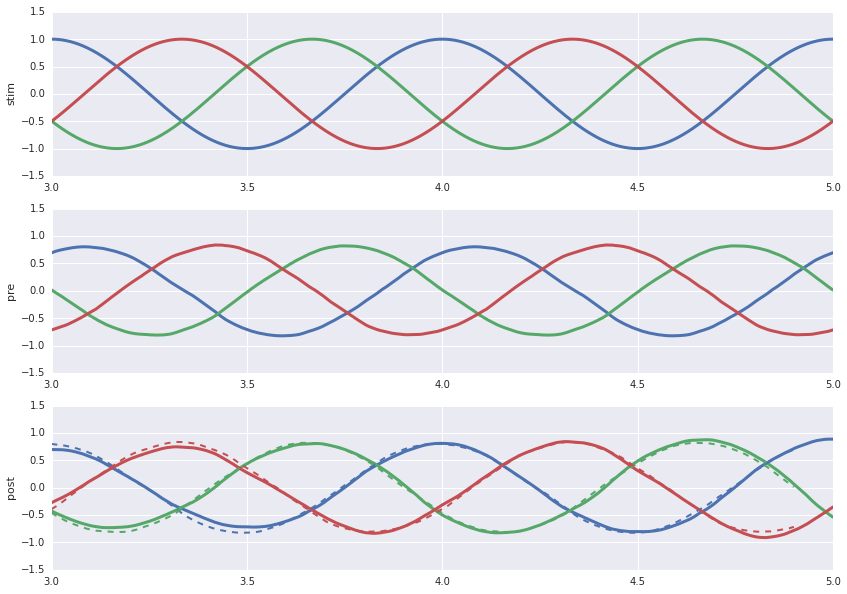

In [3]:
pylab.subplot(3, 1, 1)
pylab.plot(sim.trange(), sim.data[p_stim], lw=3)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('stim')
pylab.subplot(3, 1, 2)
pylab.plot(sim.trange(), sim.data[p_pre], lw=3)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('pre')
pylab.subplot(3, 1, 3)
pylab.plot(sim.trange(), sim.data[p_post], lw=3)
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange()-delay_synapse, sim.data[p_pre], ls='--', lw=2)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('post')
pylab.show()

The top graph shows the raw stimulus, the middle shows the contents of ```pre```, and the bottom shows the contents of ```post```.  The dotted line in the bottom graph is ```pre``` shifted by 0.1s.

This seems to work, in that the function computed between pre and post is $x_{t-\delta} \rightarrow x_t$.  However, there's one rather annoying problem here.

Because ```pre``` is shifted backwards in time, this means that the system is always predicting *the current state*.  That is, it's generating $x_t$.  What we really want is $x_{t} \rightarrow x_{t+\delta}$.  This is exactly the same function, of course.  So if we had some other mechanism that could let us optionally feed $x_t$ into ```pre``` without the delay, then it would correctly predict the future, as we wanted.  But we'd need to add that extra control flow of information, and we'd need to disable learning while we were doing this as well.  That is, we'd have a system that can predict the future, but can't learn at the same time as it is predicting the future.

So, what can we do about this?

Let's change how we do the delay.   Let's get rid of the delay from ```stim``` to ```pre```, so ```pre``` is representing $x_t$.  Instead, let's delay the connection from ```post``` to ```error```.  This will mean that the error is exactly the same as before; we've just moved the filter from ```stim->pre``` to ```post->error``` (so instead of ```stim->delay->pre->post->error``` it's ```stim->pre->post->delay->error```).

However, we now have to be careful how we're applying this error.  The error is the error for the prediction *that occurred in the past*.  If we just connect that to the learning rule as normal, then it'll be applying that error to adjust the activities of the neurons that *are currently firing*, rather than the ones that fired in the past that caused the error in the first place!  In other words, our learning rule is $\Delta d = \alpha a_t E$ (where E is the error), but what we want is $\Delta d = \alpha a_{t-\delta} E$.

Fortunately, we can do this!  When we implement the PES learning rule, we apply a synapse to the neuron activity to get $a$.  So let's set that to a long value as well! 

In [4]:
D = 3
T = 5
seed = 1

model = nengo.Network(seed=seed)
model.config[nengo.Ensemble].neuron_type=nengo.LIFRate()
with model:
    delay_synapse=0.1    
    stim = nengo.Node(lambda t: np.cos(2*np.pi*t + np.arange(D)*2*np.pi/D))
    
    pre = nengo.Ensemble(n_neurons=500, dimensions=D, radius=1)
    post = nengo.Node(None, size_in=D)
    error = nengo.Node(None, size_in=D)
    
    nengo.Connection(stim, pre, synapse=None)
        
    c = nengo.Connection(pre, post, synapse=None,
                         function=lambda x: np.zeros(D),
                         learning_rule_type=nengo.PES(learning_rate=1e-4,
                                                      pre_synapse=delay_synapse))   # delay here
    
    nengo.Connection(stim, error, transform=-1, synapse=None)
    nengo.Connection(post, error, transform=1, synapse=delay_synapse)     # and a delay here
    nengo.Connection(error, c.learning_rule, synapse=0)
    
    p_pre = nengo.Probe(pre, synapse=None)
    p_stim = nengo.Probe(stim, synapse=None)
    p_post = nengo.Probe(post, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

Simulation finished in 0:00:02.                                                 


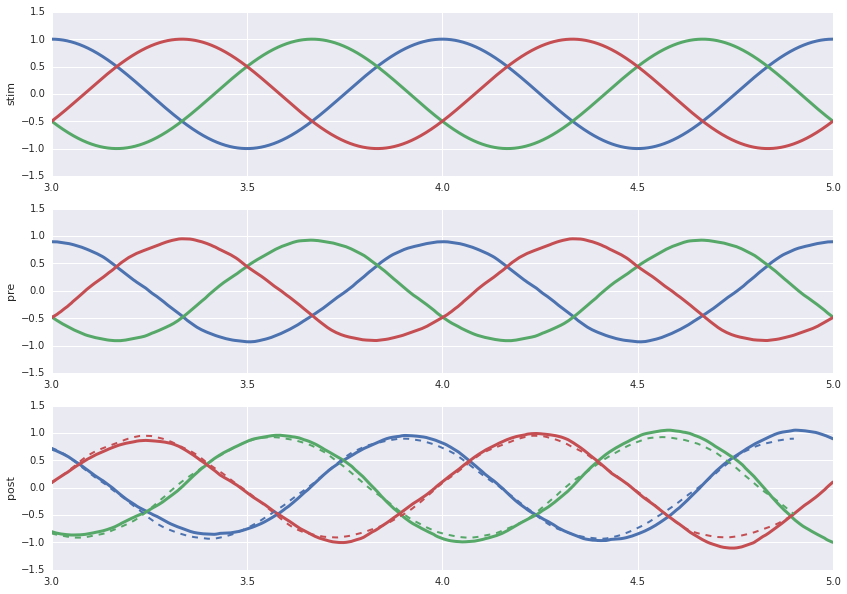

In [5]:
pylab.subplot(3, 1, 1)
pylab.plot(sim.trange(), sim.data[p_stim], lw=3)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('stim')
pylab.subplot(3, 1, 2)
pylab.plot(sim.trange(), sim.data[p_pre], lw=3)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('pre')
pylab.subplot(3, 1, 3)
pylab.plot(sim.trange(), sim.data[p_post], lw=3)
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange()-delay_synapse, sim.data[p_pre], ls='--', lw=2)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('post')
pylab.show()

Now we are predicting the future, and learning the future at the same time!  

## Delays rather than low pass filters

One rather questionable aspect of the above argument is that we're using a Low-pass filter and pretending it's a delay.  That's vaguely okay for some inputs, like the low-frequency sine wave I've been using so far.  But it really seems like it might be bad for other inputs.

Fortunately, Aaron has implemented his awesome delay stuff, and in that is a synapse that acts as a delay.  So let's use that instead!

It should be noted that in order to run this, we need the ```pes-synapse``` branch of nengo, which allows arbitrary synapses for the learning rules, rather than just allowing low-pass filters.

In [6]:
D = 3
T = 5
seed = 1

model = nengo.Network(seed=seed)
model.config[nengo.Ensemble].neuron_type=nengo.LIFRate()
with model:
    delay = 0.1
    delay_synapse=z**(-int(delay/0.001))   
    stim = nengo.Node(lambda t: np.cos(2*np.pi*t + np.arange(D)*2*np.pi/D))
    
    pre = nengo.Ensemble(n_neurons=500, dimensions=D, radius=1)
    post = nengo.Node(None, size_in=D)
    error = nengo.Node(None, size_in=D)
    
    nengo.Connection(stim, pre, synapse=None)
        
    c = nengo.Connection(pre, post, synapse=None,
                         function=lambda x: np.zeros(D),
                         learning_rule_type=nengo.PES(learning_rate=1e-4,
                                                      pre_synapse=delay_synapse))   # delay here
    
    nengo.Connection(stim, error, transform=-1, synapse=None)
    nengo.Connection(post, error, transform=1, synapse=delay_synapse)     # and a delay here
    nengo.Connection(error, c.learning_rule, synapse=0)
    
    p_pre = nengo.Probe(pre, synapse=None)
    p_stim = nengo.Probe(stim, synapse=None)
    p_post = nengo.Probe(post, synapse=None)
    
sim = nengo.Simulator(model)
sim.run(T)

Simulation finished in 0:00:04.                                                 


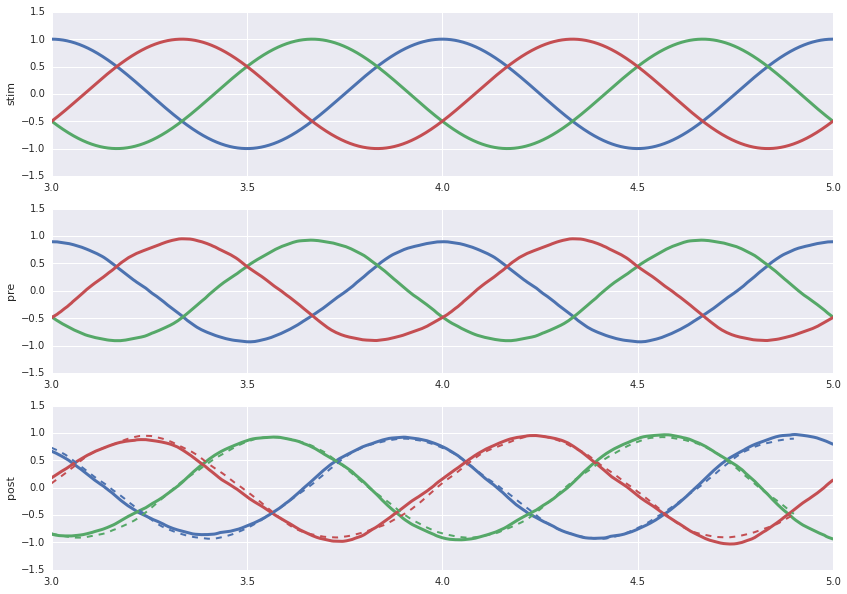

In [7]:
pylab.subplot(3, 1, 1)
pylab.plot(sim.trange(), sim.data[p_stim], lw=3)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('stim')
pylab.subplot(3, 1, 2)
pylab.plot(sim.trange(), sim.data[p_pre], lw=3)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('pre')
pylab.subplot(3, 1, 3)
pylab.plot(sim.trange(), sim.data[p_post], lw=3)
pylab.gca().set_color_cycle(None)
pylab.plot(sim.trange()-delay, sim.data[p_pre], ls='--', lw=2)
pylab.xlim(T-2, T)
pylab.ylim(-1.5,1.5)
pylab.ylabel('post')
pylab.show()

This works, and looks a bit better!

## Parameter Exploration: pytry

Let's package this up in pytry so we can start measuring accruacy and exploring how parameters affect the system.

In [8]:
import pytry

class FuturePredictor(pytry.NengoTrial):
    def params(self):
        self.param('dimensions', D=4)
        self.param('number of neurons', n_neurons=100)
        self.param('learned delay', delay=0.1)
        self.param('use z synapse', use_z_synapse=False)
        self.param('delay input to pre', delay_pre=True)
        self.param('signal type [sine|white|square]', signal='sine')
        self.param('max freq for white signal', max_white_freq=2)
        self.param('period', period=1)
        self.param('iterations', iterations=20)
        self.param('learning rate', learning_rate=1e-4)
        self.param('radius', radius=1)
        self.param('learning iterations to plot', show_iterations=1, system=True)
        
    def model(self, p):
        model = nengo.Network()
        model.config[nengo.Ensemble].neuron_type=nengo.LIFRate()
        with model:
            if p.use_z_synapse:
                delay_synapse=z**(-int(p.delay/p.dt))
            else:
                delay_synapse=p.delay
                
            if p.signal == 'sine':
                stim = nengo.Node(lambda t: np.cos(2*np.pi/p.period*t + np.arange(p.D)*2*np.pi/p.D))
            elif p.signal == 'white':
                stim = nengo.Node(nengo.processes.WhiteSignal(period=p.period, high=p.max_white_freq), size_out=p.D)
            elif p.signal == 'square':
                stim = nengo.Node(lambda t: np.eye(p.D)[int((t/p.delay))%p.D])    
            else:
                raise AttributeError('unknown signal: '+p.signal)
                
            pre = nengo.Ensemble(n_neurons=p.n_neurons, dimensions=p.D, radius=p.radius)
            c_stim_pre = nengo.Connection(stim, pre, synapse=None)

            post = nengo.Node(None, size_in=p.D)
            c_pre_post = nengo.Connection(pre, post, synapse=None,
                                          function=lambda x: np.zeros(p.D),
                                          )
            
            # turn off the error for the last iteration
            error = nengo.Node(lambda t, x: x if t<p.period*p.iterations else x*0, size_in=p.D)

            nengo.Connection(stim, error, transform=-1, synapse=None)
            c_post_error = nengo.Connection(post, error, transform=1, synapse=None)
            
            if p.delay_pre:
                c_stim_pre.synapse = delay_synapse
                c_pre_post.learning_rule_type=nengo.PES(learning_rate=p.learning_rate,
                                                        pre_synapse=None)
            else:
                c_post_error.synapse = delay_synapse
                c_pre_post.learning_rule_type=nengo.PES(learning_rate=p.learning_rate,
                                                        pre_synapse=delay_synapse)
                
            nengo.Connection(error, c_pre_post.learning_rule, synapse=0)
            
            self.p_pre = nengo.Probe(pre, synapse=None)
            self.p_stim = nengo.Probe(stim, synapse=None)
            self.p_post = nengo.Probe(post, synapse=None)
        return model
    
    def evaluate(self, p, sim, plt):
        sim.run(p.period*(p.iterations+1))
        
        d_pre = sim.data[self.p_pre]
        d_post = sim.data[self.p_post]
        offset = int(p.delay/p.dt)
        d_pre = d_pre[offset:]
        d_post = d_post[:-offset]
        rmse_half = np.sqrt(np.mean((d_pre[len(d_pre)/2:]-d_post[len(d_post)/2:])**2))
        period = int(p.period/p.dt)
        d_pre = d_pre[-period:]
        d_post = d_post[-period:]
        rmse_last = np.sqrt(np.mean((d_pre-d_post)**2))
        
        
        if plt:
            plt.subplot(4, 1, 1)
            plt.plot(sim.trange(), sim.data[self.p_stim], lw=3)
            plt.xlim(p.period*(p.iterations-p.show_iterations), p.period*(p.iterations+1))
            plt.ylim(-1.5,1.5)
            plt.ylabel('stim')
            plt.axvline(p.period*p.iterations, c='0.5')
            plt.subplot(4, 1, 2)
            plt.plot(sim.trange(), sim.data[self.p_pre], lw=3)
            plt.xlim(p.period*(p.iterations-p.show_iterations), p.period*(p.iterations+1))
            plt.ylim(-1.5,1.5)
            plt.ylabel('pre')
            plt.axvline(p.period*p.iterations, c='0.5')
            plt.subplot(4, 1, 3)
            plt.plot(sim.trange(), sim.data[self.p_post], lw=3)
            plt.gca().set_color_cycle(None)
            plt.plot(sim.trange()-p.delay, sim.data[self.p_pre], ls='--', lw=2)
            plt.xlim(p.period*(p.iterations-p.show_iterations), p.period*(p.iterations+1))
            plt.ylim(-1.5,1.5)
            plt.ylabel('post')
            plt.axvline(p.period*p.iterations, c='0.5')
            
            plt.subplot(4,1,4)
            plt.plot(sim.trange()[:-offset], sim.data[self.p_pre][offset:]-sim.data[self.p_post][:-offset], lw=1)
            plt.xlim(p.period*(p.iterations-p.show_iterations), p.period*(p.iterations+1))
            plt.ylabel('error')
            plt.axvline(p.period*p.iterations, c='0.5')
            
        return dict(rmse_last=rmse_last,
                    rmse_half=rmse_half)


This provides three different stimuli: the sine waves we've seen above, a random white noise signal, and a sqaure wave.  The square wave is set up to change values (from 1,0,0 to 0,1,0, to 0,0,1 and back to 1,0,0) with an interval that's the same as the prediction delay (so whenever it's outputing 1,0,0 the prediction should be 0,1,0).

Also, we run learning for the specified number of iterations, and then do one more iteration with learning turned off.  This allows us to make sure that it has actually learned something.  The vertical line in the graph shows when learning is turned off.

We measure the rmse for the last iteration (the one with learning off) and also measure it over the last half of the whole simulation.

Let's see what this looks like for the sine wave again (although at 4 dimensions this time, just to be different)

Simulation finished in 0:00:07.                                                 


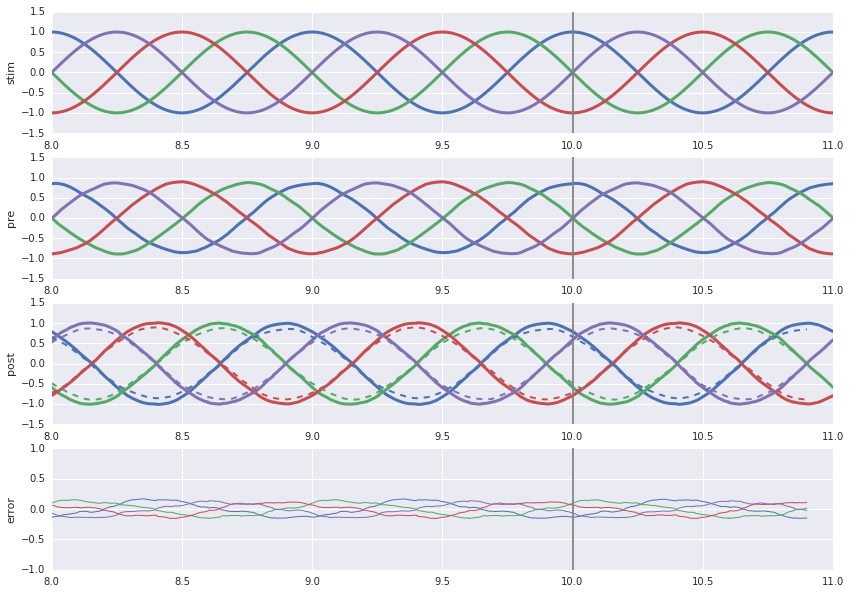

{'rmse_half': 0.092759716590732524, 'rmse_last': 0.094505498656443657}

In [9]:
FuturePredictor().run(show_iterations=2, show_figs=True, hide_overlay=True, verbose=False, 
                      iterations=10, n_neurons=500, D=4, 
                      delay_pre=False, use_z_synapse=True,
                      signal='sine', period=1.0,
                      delay=0.1)

And here's the white noise signal

Simulation finished in 0:00:08.                                                 


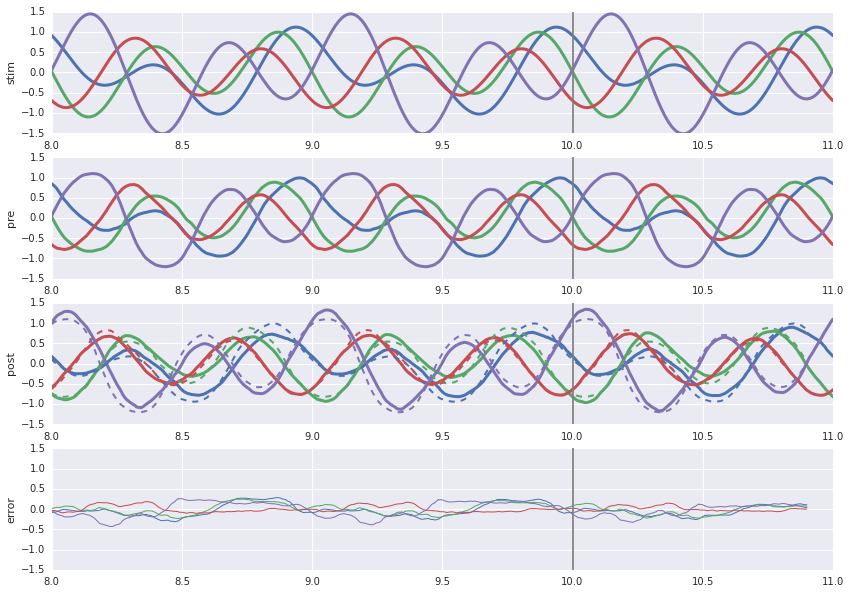

{'rmse_half': 0.17025251084838788, 'rmse_last': 0.11245739325363333}

In [10]:
FuturePredictor().run(show_iterations=2, show_figs=True, hide_overlay=True, verbose=False, 
                      iterations=10, n_neurons=500, D=4, 
                      delay_pre=False, use_z_synapse=True,
                      signal='white', period=1.0,
                      delay=0.1)

And the square wave

Simulation finished in 0:00:07.                                                 


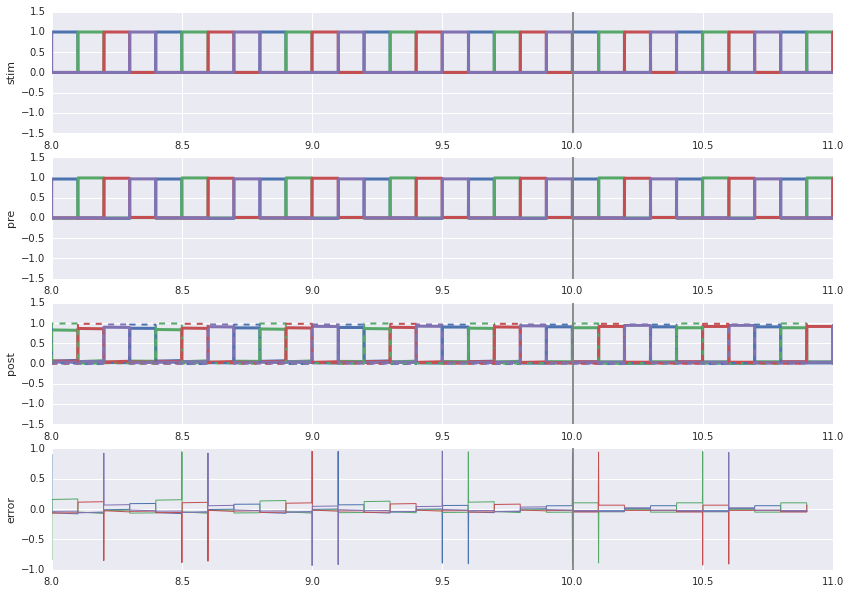

{'rmse_half': 0.087988560204622118, 'rmse_last': 0.061371239303439462}

In [11]:
FuturePredictor().run(show_iterations=2, show_figs=True, hide_overlay=True, verbose=False, 
                      iterations=10, n_neurons=500, D=4, 
                      delay_pre=False, use_z_synapse=True,
                      signal='square', period=1.0,
                      delay=0.1)

Let's check how well this works across different parameter settings

In [100]:
for seed in range(2,20):
    print('seed: %d' % seed)
    for signal in ['sine', 'white', 'square']:
        for delay_pre in [True, False]:
            for use_z_synapse in [True, False]:
                FuturePredictor().run(
                    show_iterations=2, verbose=False,
                    data_dir='exp1',
                    seed=seed,
                    iterations=10, n_neurons=500, D=4, 
                    delay_pre=delay_pre, use_z_synapse=use_z_synapse,
                    signal=signal, period=1.0,
                    delay=0.1)
                

seed: 2
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished in 0:00:04.                                                 
seed: 3
Simulation f

In [113]:
data = pytry.read('exp1')
for d in data:
    mode = 'z' if d['use_z_synapse'] else 'lp'
    mode += '|present' if d['delay_pre'] else '|future'
    d['mode']=mode
df = pandas.DataFrame(data)

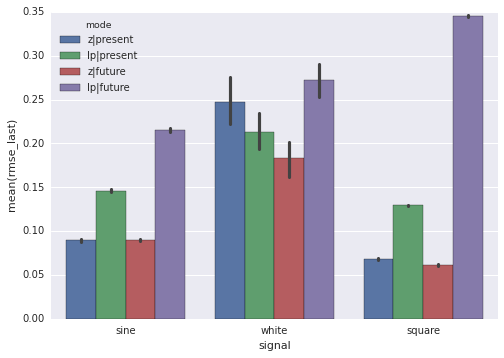

In [114]:
seaborn.barplot('signal', 'rmse_last', data=df, hue='mode')

Using z and predicting the future seems like a pretty good win overall, but that's a pretty complex pattern.  Does dimensionality affect it?

In [101]:
for seed in range(0,20):
    print('seed: %d' % seed)
    for signal in ['sine', 'white', 'square']:
        for delay_pre in [True, False]:
            for use_z_synapse in [True, False]:
                for D in [2, 4, 6, 8]:
                    FuturePredictor().run(
                        show_iterations=2, verbose=False,
                        data_dir='exp2',
                        seed=seed,
                        iterations=10, n_neurons=500, D=D, 
                        delay_pre=delay_pre, use_z_synapse=use_z_synapse,
                        signal=signal, period=1.0,
                        delay=0.1)


seed: 0
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:03.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:04.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished in 0:00:07.                                                 
Simulation finished 

In [115]:
data = pytry.read('exp2')
for d in data:
    mode = 'z' if d['use_z_synapse'] else 'lp'
    mode += '|present' if d['delay_pre'] else '|future'
    d['mode']=mode
df = pandas.DataFrame(data)

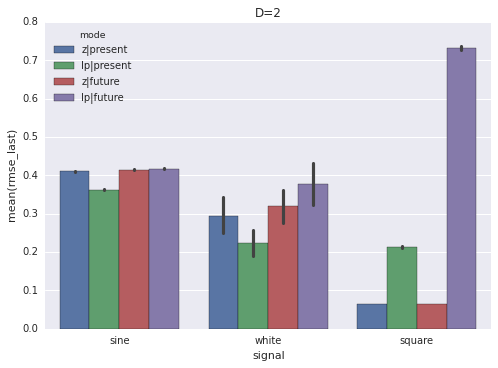

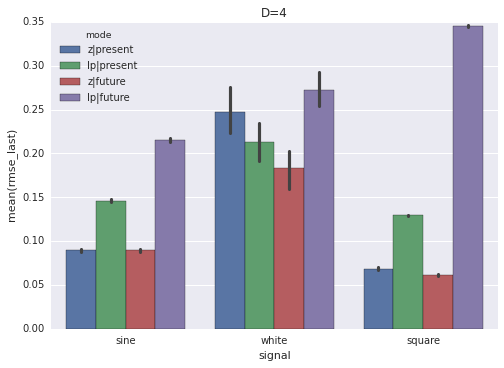

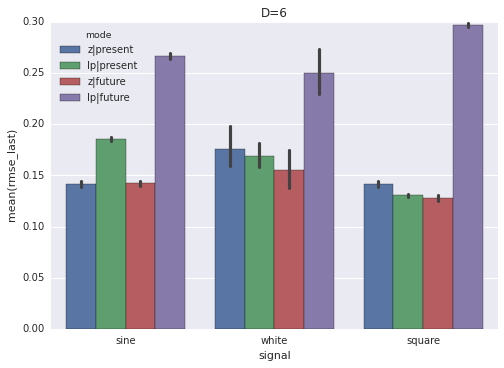

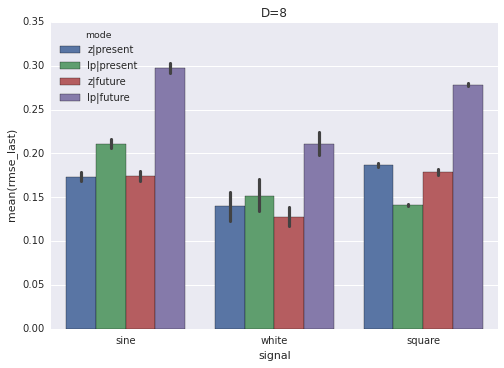

In [119]:
for D in [2, 4, 6, 8]:
    pylab.figure()
    seaborn.barplot('signal', 'rmse_last', data=df.query('D==%d' % D), hue='mode')
    pylab.title('D=%d' % D)
pylab.show()

Yikes, that's a complicated pattern.  More research should be done!